In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [134]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

Autosave disabled


# PyTorch tutorial

- https://github.com/magister-informatica-uach/INFO267/blob/master/unidad1/3_redes_neuronales.ipynb
- https://github.com/magister-informatica-uach/INFO267/blob/master/unidad1/4_red_convolucional.ipynb


# Linear Regression

In linear regression we have a 
- continuous one-dimensional target $y$ 
- continuous M-dimensional input $x$ 

related by a linear mapping

$$
b + \sum_{d=1}^D w_d x_d = f_\theta(x)  \rightarrow y
$$

> The model is specified by $\theta=(b, w_1, w_2, \ldots, w_D)$

Typically, we fit this model by 
$$
\min_\theta\sum_n \left(y_n - f_\theta(x_n) \right)^2 = (Y - \Phi \theta)^T (Y - \Phi \theta)
$$

whose solution is

$$
\theta = (\Phi^T \Phi)^{-1} \Phi^T Y,
$$

where $\Phi  = \begin{pmatrix} 1 & x_{11} & x_{12} & \ldots & x_{1D} \\ 
1 & x_{21} & x_{22} & \ldots & x_{2D} \\
1 & \vdots & \vdots & \ddots & \vdots \\
1 & x_{N1} & x_{N2} & \ldots & x_{ND} \end{pmatrix}$,  $Y = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{pmatrix}$ and  $\theta =  \begin{pmatrix} b \\ w_1 \\ \vdots \\ w_D \end{pmatrix}$

> This is known as the ordinary least squares (OLS) solution

#### Note: Linear regression is *linear on the parameters*

If we apply transformations we obtain the same solution. The only difference is in $\Phi$

For example
- Polynomial basis regression $f_\theta(x) = \sum_d w_d x^d + b$ 
- Sine-wave basis regression $f_\theta(x) = \sum_d \alpha_d \cos(2\pi d f_0 x)  + \sum_d \beta_d \sin(2\pi d f_0 x) + c$ 

### Probabilistic linear regression

We can assume that observations are noisy and write

$$
y = f_\theta(x) + \epsilon = b + \sum_{d=1}^D w_d x_d   + \epsilon,
$$

If the noise is independent and Gaussian distributed (iid) with variance $\sigma_\epsilon^2$ then

$$
p(y|x, \theta) = \mathcal{N}\left(y| f_\theta(x) , \sigma_\epsilon^2 \right)
$$

Additionally, we may want to discourage large values of $\theta~$ by placing a prior

$$
p(\theta) = \mathcal{N}(0, \Sigma_\theta)
$$

The prior on the parameters gives us the space of possible models (before presenting data)

<IPython.core.display.Javascript object>


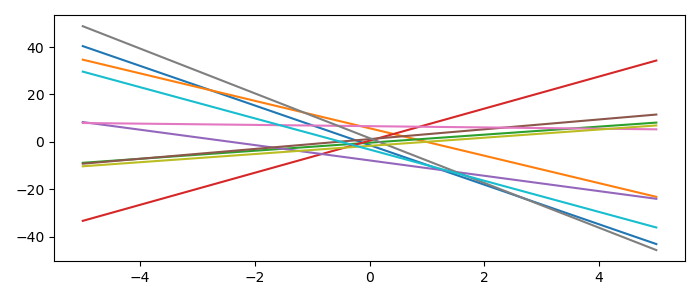

In [52]:
import torch

x = np.linspace(-5, 5, num=100)[:, None].astype('float32') #100x1

sw, sb = 5., 5.
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
for i in range(10):
    linear_layer = torch.nn.Linear(1, 1)
    #W = sw*np.random.randn(1)
    #b = sb*np.random.randn(1)
    torch.nn.init.normal_(linear_layer.weight, 0.0, sw)
    torch.nn.init.normal_(linear_layer.bias, 0.0, sb)
    #y = W*x + b
    y = linear_layer(torch.from_numpy(x)).detach().numpy()
    ax.plot(x, y, label='w: %0.2f, b: %0.2f' %(linear_layer.weight, linear_layer.bias))
#plt.legend()

We constraint the space of solutions by presenting data

### Point-estimate solution (MAP)

For a dataset $\mathcal{D} = \{ (x_1, y_1), (x_2, y_2), \ldots, (x_N, y_N) \}$

The Maximum a posteriori estimator of $\theta~$ is given by
$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log p(\mathcal{D}| \theta, \sigma_\epsilon^2) ~ \mathcal{N} (\theta|0, \Sigma_\theta) \nonumber  \\
&= \text{arg}\min_\theta  \frac{1}{2\sigma_\epsilon^2} (Y-\Phi\theta)^T (Y - \Phi\theta) + \frac{1}{2} \theta^T \Sigma_\theta^{-1} \theta  \nonumber
\end{align}
$$
where the log likelihood is
$$
\log p(\mathcal{D}| \theta, \sigma_\epsilon^2) = \sum_{n=1}^N \log \mathcal{N}(y_n|f_\theta(x_n),\sigma_\epsilon^2)
$$
and the result is
$$
\hat \theta = (\Phi^T \Phi + \lambda )^{-1} \Phi^T Y
$$
where $\lambda = \sigma_\epsilon^2 \Sigma_\theta^{-1}$

> This is the ridge regression or **regularized least squares** solution

What happens if the variance of the prior tends to infinite (uninformative prior)

We get MLE : ordinary least squares solution

### Bayesian solution for the parameters

In this case we want the posterior of $\theta~$ given the dataset

Assuming that we know $\sigma_\epsilon$

$$
p(\theta|\mathcal{D}, \sigma_\epsilon^2) \propto  \mathcal{N}(Y| \Phi \theta, I\sigma_\epsilon^2) \mathcal{N}(\theta| \theta_0, \Sigma_{\theta_0})
$$

The likelihood is normal and the prior is normal, so
$$
\begin{align}
p(\mathcal{D}| \theta, \sigma_\epsilon^2) p(\theta|\theta_0, \Sigma_{\theta_0}) = \frac{1}{Z} \exp \left ( -\frac{1}{2\sigma_\epsilon^2} (Y-\Phi\theta)^T (Y - \Phi\theta)  - \frac{1}{2} (\theta - \theta_{0})^{T} \Sigma_{\theta_0}^{-1} (\theta - \theta_0)\right)
\end{align}
$$

(With a bit of algebra) This corresponds to a normal distribution with parameters 
$$
\Sigma_{\theta_1} = \sigma_\epsilon^2 (\Phi^T \Phi + \sigma_\epsilon^2  \Sigma_{\theta_0}^{-1})^{-1}
$$
$$
\theta_1 = \Sigma_{\theta_1} \Sigma_{\theta_0}^{-1} \theta_{0} + \frac{1}{\sigma_\epsilon^2} \Sigma_{\theta_1} \Phi^T y
$$

> **Iterative framework:** We can present data and update the distribution of $\theta~$

In [27]:
# Initialization
mw, mb = 0., 0.
sw, sb = 5., 5.
So = np.diag(np.array([sb, sw])**2)
mo = np.array([mb, mw])
seps = 0.25 # What happens if this is larger/smaller?

Sample $x=2$, $y=0$ is presented

In [28]:
#Update
Phi = np.array([[1.0, 2.0]])
y = np.array([0.0])
Sn = seps**2*np.linalg.inv(np.dot(Phi.T, Phi) +  seps**2*np.linalg.inv(So))
mn = np.dot(Sn, np.linalg.solve(So, mo)) + np.dot(Sn, np.dot(Phi.T, y))/seps**2
display(Sn, mn)

array([[20.00249875, -9.9950025 ],
       [-9.9950025 ,  5.009995  ]])

array([0., 0.])

Now the space of possible models is constrained

<IPython.core.display.Javascript object>


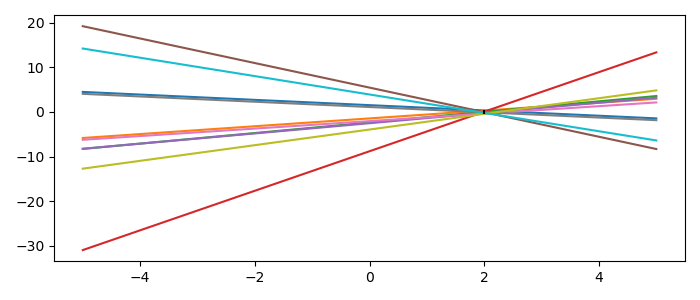

In [29]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

for i in range(10):
    linear_layer = torch.nn.Linear(1, 1)
    rparam = torch.from_numpy(np.random.multivariate_normal(mn, Sn).astype('float32'))
    linear_layer.weight.data = rparam[1].reshape(-1, 1)
    linear_layer.bias.data = rparam[0].reshape(-1, 1)
    y = linear_layer(torch.from_numpy(x)).detach().numpy()
    ax.plot(x, y)

ax.errorbar(2, 0, xerr=0, yerr=2*seps, fmt='none', c='k', zorder=100);
#ax.errorbar(-2, -2., xerr=0, yerr=2*seps, fmt='none', c='k');

If we present now $x=-2$, $y=-2$

In [32]:
# Initialization
So = Sn
mo = mn
#Update
Phi = np.array([[1.0, -2.0]])
y = np.array([-2.0])
Sn = seps**2*np.linalg.inv(np.dot(Phi.T, Phi) +  seps**2*np.linalg.inv(So))
mn = np.dot(Sn, np.linalg.solve(So, mo)) + np.dot(Sn, np.dot(Phi.T, y))/seps**2
display(Sn, mn)

array([[ 3.12109863e-02, -2.78854660e-16],
       [-2.78854660e-16,  7.81005936e-03]])

array([-0.99875156,  0.4998438 ])

Then

<IPython.core.display.Javascript object>


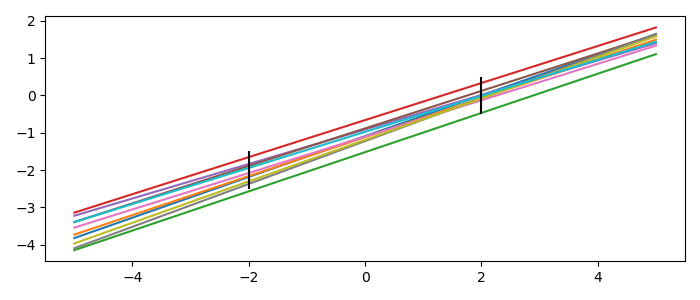

In [33]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

for i in range(10):
    linear_layer = torch.nn.Linear(1, 1)
    rparam = torch.from_numpy(np.random.multivariate_normal(mn, Sn).astype('float32'))
    linear_layer.weight.data = rparam[1].reshape(-1, 1)
    linear_layer.bias.data = rparam[0].reshape(-1, 1)
    y = linear_layer(torch.from_numpy(x)).detach().numpy()
    ax.plot(x, y)

ax.errorbar(2, 0, xerr=0, yerr=2*seps, fmt='none', c='k', zorder=100);
ax.errorbar(-2, -2., xerr=0, yerr=2*seps, fmt='none', c='k', zorder=100);

### Bayesian solution for the predictions

What we want

> We train the model to predict $y$ for new values of $x$

In the Bayesian setting we are interested in the **posterior predictive distribution**

$$
\begin{align}
p(y|x, \mathcal{D}, \sigma_\epsilon^2) &= \int p(y|f_\theta(x), \sigma_\epsilon^2) p(\theta| \theta_{N}, \Sigma_{\theta_N}) d\theta \nonumber \\
&= \mathcal{N}\left(y|f_{\theta_N} (x), \sigma_\epsilon^2 + x^T \Sigma_{\theta_N} x\right)
\end{align}
$$

If we consider that $N$ samples were presented and that $\mu_0=0$ then 

$$
\theta_{N} =  (\Phi^T \Phi + \sigma_\epsilon^2 \Sigma_{\theta_0}^{-1})^{-1} \Phi^T y
$$

(MAP estimator) and

$$
\Sigma_{\theta_N} = \sigma_\epsilon^2 (\Phi^T \Phi + \sigma_\epsilon^2 \Sigma_{\theta_0}^{-1})^{-1}
$$


And the variance (uncertainty) for the new $x$ is 
$$
\sigma^2(x) = \sigma_\epsilon^2 + x^T \Sigma_{\theta_N} x
$$

> The variance of the prediction has contribution from the noise (irreducible) and the model 

Uncertainty grows when we depart from the observed data points

<IPython.core.display.Javascript object>


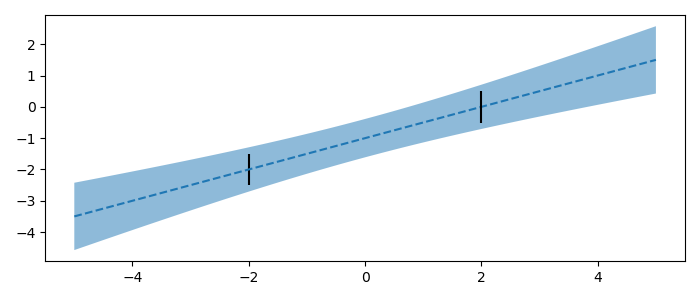

In [36]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

Phi_x = np.vstack(([1]*100, x[:, 0])).T
sx = np.sqrt(np.diag(seps**2 + np.dot(np.dot(Phi_x, Sn), Phi_x.T)))
ax.plot(x, np.dot(Phi_x, mn), '--')
ax.fill_between(x[:, 0], np.dot(Phi_x, mn)-2*sx, np.dot(Phi_x, mn)+2*sx, alpha=0.5)
ax.errorbar(2, 0, xerr=0, yerr=2*seps, fmt='none', c='k', zorder=100);
ax.errorbar(-2, -2., xerr=0, yerr=2*seps, fmt='none', c='k');

See how this changes with increasing/decreasing $\sigma_\epsilon$ and $\Sigma_{\theta_0}$

# Self-study

- [Chapter 18 of D. Barber's book](http://web4.cs.ucl.ac.uk/staff/D.Barber/pmwiki/pmwiki.php?n=Brml.Online)

# Linear regression with Pytorch

Let's create synthetic data

We will fit this with a polynomial model

<IPython.core.display.Javascript object>


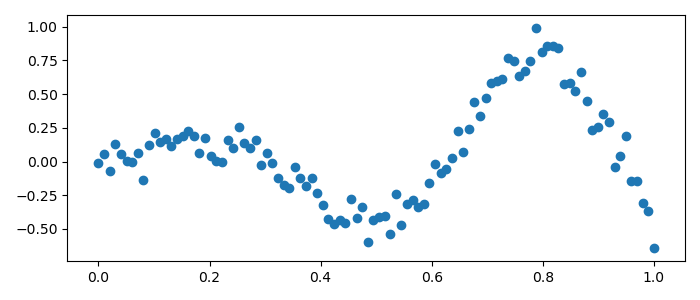

In [221]:
# Synthetic data
x = np.linspace(0, 1, num=100).astype('float32') #100x1
y_clean = x*np.sin(10*x)
y = y_clean + 0.1*np.random.randn(len(x))
y = y.astype('float32')
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

The linear regressor model in PyTorch is a neural network with one layer and no activation

We train this with MSE loss and using batch GD with adaptive learning rate and momentum (Adam)

With the `weight_decay` parameters of Adam we can add L2 regularization easily

<IPython.core.display.Javascript object>


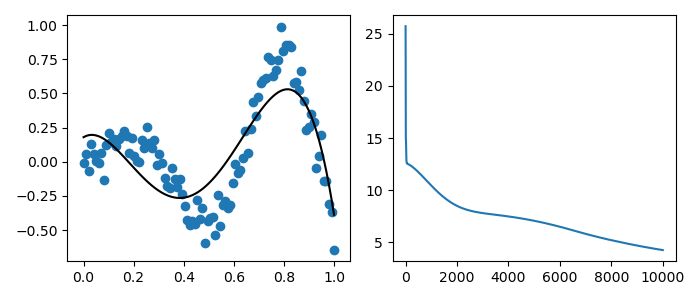

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)

class LinearRegressor(torch.nn.Module):
    def __init__(self, degree=4):
        super(LinearRegressor, self).__init__()
        self.degree = degree
        self.linear = torch.nn.Linear(1+degree, 1, bias=True)

    def forward(self, x):
        phi = torch.stack([x**k for k in range(self.degree+1)], dim=-1)
        return self.linear(phi)
    
model = LinearRegressor()
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, 
                             amsgrad=False, weight_decay=0.0)

x_torch = torch.from_numpy(x)
y_torch = torch.from_numpy(y).unsqueeze(1)

f = model.forward(torch.from_numpy(x)).detach().numpy()
line = ax[0].plot(x, f, 'k-')

ax[0].scatter(x, y)
epoch_loss = np.zeros(shape=(10000,))
for k in tqdm_notebook(range(len(epoch_loss))):
    optimizer.zero_grad()
    f = model.forward(x_torch)
    loss = criterion(y_torch, f)
    loss.backward()
    optimizer.step()
    epoch_loss[k] = loss.item()
    #break    
    if k % 100 == 0:
        f = model.forward(torch.from_numpy(x)).detach().numpy()
        line[0].set_ydata(f)
        fig.canvas.draw()
#ax[0].plot(x, f, 'k-')
ax[1].plot(epoch_loss);

# Bayesian Linear Regression with Pyro

In [258]:
import pyro
from pyro.distributions import Normal, Uniform

regressor = LinearRegressor(degree=20)

def model(x_data, y_data):
    # weight and bias priors
    w_prior = Normal(torch.zeros(1, regressor.degree+1), torch.ones(1, regressor.degree+1)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)

    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
    scale = pyro.sample("sigma", Uniform(0., 10.))
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regressor, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean


    
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

optim = pyro.optim.Adam({"lr": 0.01})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=1000)

pyro.clear_param_store()
epoch_loss = np.zeros(shape=(10000,))
for k in tqdm_notebook(range(len(epoch_loss))):
    loss = svi.step(x_torch, y_torch)
    if k % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (k + 1, loss / len(data)))



[iteration 0001] loss: 49839.2188
[iteration 0101] loss: 33507.0071
[iteration 0201] loss: 31462.9836
[iteration 0301] loss: 30709.3735
[iteration 0401] loss: 27100.7703
[iteration 0501] loss: 26613.3280
[iteration 0601] loss: 24571.1638
[iteration 0701] loss: 29763.3607
[iteration 0801] loss: 27006.0917
[iteration 0901] loss: 23754.8998
[iteration 1001] loss: 23802.5691
[iteration 1101] loss: 23622.4128
[iteration 1201] loss: 21799.7818
[iteration 1301] loss: 20603.2037
[iteration 1401] loss: 20084.8704
[iteration 1501] loss: 21625.1675
[iteration 1601] loss: 20361.6760
[iteration 1701] loss: 19029.2859
[iteration 1801] loss: 17784.7571
[iteration 1901] loss: 17513.6425
[iteration 2001] loss: 16615.7099
[iteration 2101] loss: 15858.4664
[iteration 2201] loss: 15820.8335
[iteration 2301] loss: 15833.3769
[iteration 2401] loss: 14580.4318
[iteration 2501] loss: 13709.9596
[iteration 2601] loss: 14684.8572
[iteration 2701] loss: 13494.1008
[iteration 2801] loss: 13446.8768
[iteration 290

- http://pyro.ai/examples/bayesian_regression.html

# Artificial Neural networks

[Artificial neural networks](https://docs.google.com/presentation/d/1IJ2n8X4w8pvzNLmpJB-ms6-GDHWthfsJTFuyUqHfXg8/edit?usp=sharing) (ANN) are non-linear parametric function approximators built by connecting simple units

These units are simplified models of biological neurons: 

> linear regressor followed by a non-linear activation function

Feed-forward ANN are organized in layers. Each layer has a certain amount of neurons (user-defined)

> **Multilayer perceptron (MLP) architecture:** Every unit is connected to all units of its previous and next layers

Different ways of connecting neurons yields different ANN architectures (convolutional, recurrent, etc)

The parameter vector $\theta$ includes the weights and biases of all the neurons

- Let's consider a Gaussian prior for $\theta$ and study the space of possible models
- How does it compare to the linear regressor? 
    - What happens when you add more neurons? 
    - What happens if you remove the nonlinearity?
    - What happens when you add more layers?

<IPython.core.display.Javascript object>


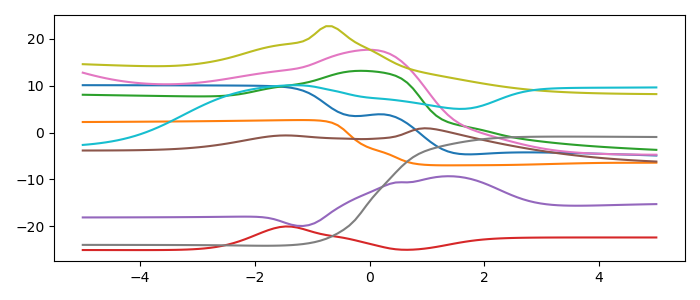

In [77]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

class MLP(torch.nn.Module):
    def __init__(self, Nh=10, sw=5, sb=5):
        super(MLP, self).__init__()
        self.hidden1 = torch.nn.Linear(1, Nh)
        self.output = torch.nn.Linear(Nh, 1)
        for layer in [self.hidden1, self.output]:
            torch.nn.init.normal_(layer.weight, 0.0, sw)
            torch.nn.init.normal_(layer.bias, 0.0, sb)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        z = self.activation(self.hidden1(x))
        return self.output(z)
    
for i in range(10):
    model = MLP()
    y = model.forward(torch.from_numpy(x)).detach().numpy()
    ax.plot(x, y)

## Probabilistic interpretation of ANN

Let's consider a simple MLP architecture for regression
- one hidden layer with $H$ neurons
- input dimensionality $D$ and output dimensionality $K$
- $g(\cdot)$ a nonlinear activation function (sigmoid, tanh, ReLU, etc)

The jth neuron in the hidden layer
$$
z_j =  g \left( b_j + \sum_{d=1}^D w_{jd} x_d  \right)
$$
The ith neuron in the output layer
$$
\begin{align}
f_i &=   b_i + \sum_{j=1}^H w_{ij} z_j  \nonumber \\
&=  b_i + \sum_{j=1}^H w_{ij} g \left( b_j + \sum_{d=1}^D w_{jd} x_d  \right) \nonumber
\end{align}
$$

The vector parameter $\vec \theta$ contains the weight and biases of both layers

We fit the parameters by minimizing the **Mean Square Error** cost function 

$$
\min_\theta \sum_n  \sum_i \left(y_{i}^{(n)} - f_i(x^{(n)}) \right)^2
$$

> This is equivalent to the **MLE solution with Gaussian likelihood** (known variance)

Typically an L2 regularizer is included to penalize complexity and improve generalization

$$
\min_\theta \sum_n  \sum_i  \left(y_{i}^{(n)} - f_i(x^{(n)}) \right)^2 + \lambda \sum_k \theta_k^2
$$

> This is equivalent to the **MAP solution with Gaussian likelihood and Gaussian prior** (zero-mean)

In both cases there is no closed-form solution and we optimize with iterative methods (gradient descent)


### In summary: Conventional neural network training obtains MLE/MAP point estimates

For classification we arrive to the same conclusion except that 
- sigmoid or softmax activation is used in the output layer
- cross-entropy cost function is used instead of MSE: **Bernoulli/Categorical likelihood**

# Bayesian Neural Networks

In the bayesian setting we are interested in the posterior of the parameters and predictions

Assuming *iid* samples $\mathcal{D} =\{(x^{(1)}, y^{(1)}), \ldots \}$ we can write the posterior of $\theta$

$$
p(\theta | \mathcal{D}) \propto p(\mathcal{D}|\theta) p(\theta) = \prod_n \mathcal{N}(y^{(n)} | f(x^{(n)}), \sigma^2) \mathcal{N}(\theta | 0, \Sigma_\theta)
$$

> Because of the nested nonlinearities this posterior is not Gaussian!

We have to use approximations: Laplacian method, Variational Inference

- http://pyro.ai/examples/
- https://alsibahi.xyz/snippets/2019/06/15/pyro_mnist_bnn_kl.html
- https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd
- https://github.com/paraschopra/bayesian-neural-network-mnist
- https://in.pycon.org/cfp/workshops-2019/proposals/pyro-demystified-bayesian-deep-learning~en4lb/
- https://www.reddit.com/r/MachineLearning/comments/a15r9o/p_bayesian_image_classifier_using_pyro_to_give/eangqch/
- Bayesian layers

## BIAS VARIANCE TRADE OFF